# Ultra Long Period Tilt from Broadband Seismic Data

The objective of this lab is to learn to derive ground rotation (tilt) from seismic data. Seismometers are designed to measure ground <I>translation</I> without tilt. In fact, in the derivation of seismic wave equations we assume there is no tilt and separate translational strain from rigid body rotation (see Shearer 2.2). It is a good assumption that rotation is negligible when recording seismic data far from the source. However, when measuring seismic wave close to the source, ground rotation can be observed.





Extract the tilt signal in four steps by:
<OL>
    
<LI>removing the mean,</LI>
<LI>integrating the instrument output,</LI>
<LI>low‐pass filtering below the natural frequency of the instrument, and</LI>
<LI>multiplying by a constant $-{S\omega_0^2}/{g}$ where $S$ is the seismometer sensitivity (find it in the instrument response), $\omega_0$ is the seismometer natural frequency (find that in the instrument response too) and $g=9.8 m/s^2$.
    </LI>
    </OL>
    Positive east and north components of tilt are defined as tilt down to the east and north, respectively.
    




Your assignment is to compute the tilt that preceeded an explosive eruption at Fuego at about 3:00 on 2009-01-19. Look at the station F900. Determine:<OL>
    <LI>the amplitude of the tilt signal (radians or nanoradians)</LI>
    <LI>the approximate duration of the tilt signal start to finish</LI>
    <LI>the direction of maximum tilt</LI>

## The instrument response
Before we move on to the tilt stuff, let's take a quick look at the instrument response we talked about the other day. The amplitude response is:
$$|H(\omega)|=\frac{\omega^2}{\sqrt{(\omega^2-\omega_0^2)^2+4\xi\omega_0^2\omega^2}}$$
and the phase response is:
$$\phi(\omega)=\pi - \tan^{-1}\frac{2\xi\omega_0\omega}{\omega^2-\omega_0^2}$$
where $\xi=\frac{\beta}{\omega_0}\approx0.707$

In [1]:
# load some modules
import matplotlib.pyplot as plt
import numpy as np

from obspy import UTCDateTime
from obspy.clients.fdsn import Client

irisclient = Client('IRIS')

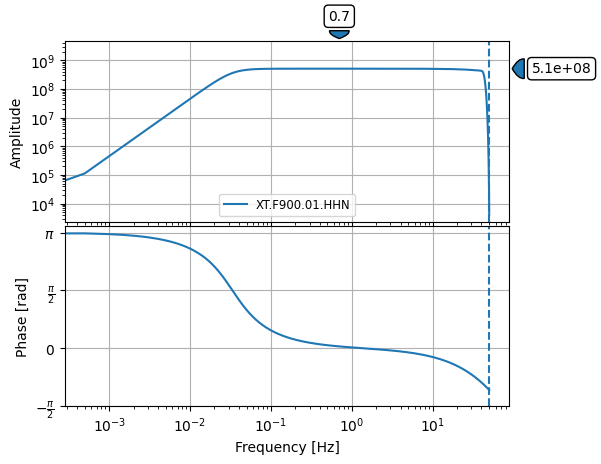

In [2]:
# Let's look at a response plot for a typical broadband station

# stime=UTCDateTime(2005,7,2,12,0,0); 
# etime=UTCDateTime(2005,7,3,12,0,0);

# inv = irisclient.get_stations(starttime=stime, endtime=etime,network="YB",sta="S01",loc="*",
#                               channel="LHN",level="response")

stime=UTCDateTime(2009,1,19,12,0,0); 
etime=UTCDateTime(2009,1,19,12,0,0);


inv = irisclient.get_stations(starttime=stime, endtime=etime,network="XT",sta="F900",loc="*",
                              channel="HHN",level="response")


# there is a built in bode plot option within the inventory
inv[0].plot_response(min_freq=0.0005, output='VEL');

# Compare this to the LHN channel
# What is the difference?

The max amplitude of the response is at  2.01 Hz
The amplitude of the corner is 3.6109e+08
The corner frequency is 0.0334 Hz
The phase of the response at the max is -1.46º 
The phase of the response at the corner is 90.12º 
That's a difference of 91.58 degrees!


/var/folders/x8/svldfg9x33xdblkb69dcj55r0000gn/T/ipykernel_38254/2134302277.py:51: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax0[0].set_xlim(np.min(freqs), 1) #limit the plot
/var/folders/x8/svldfg9x33xdblkb69dcj55r0000gn/T/ipykernel_38254/2134302277.py:53: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax0[1].set_xlim(np.min(freqs), 1) #limit the plot


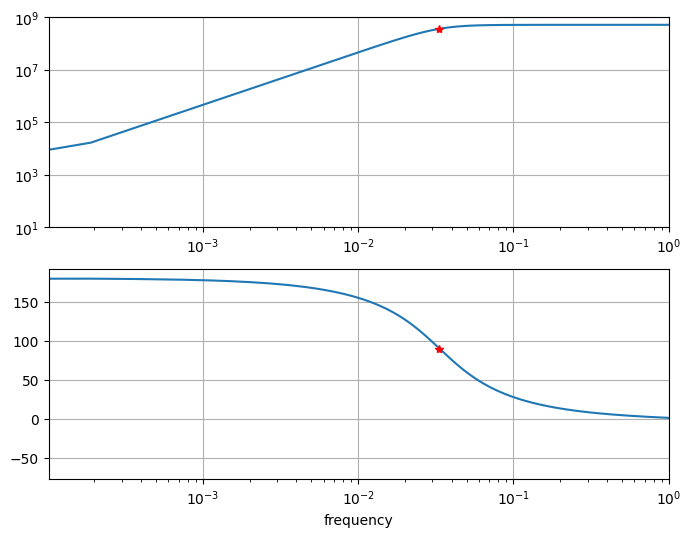

In [3]:
# But now extract the channel-level response information from the inventory
net=inv[0]
sta=net[0]
cha=sta[0]
response = cha.response ### We will use this again later to get the instrument sensitivity

# we can then evaluate the response
resp, freqs = response.get_evalresp_response(0.01, 2**19, output="VEL")

# the amplitude response is the absolute value of the response
ampresp=np.abs(resp)
fig0, ax0 = plt.subplots(2,1,figsize=(8,6))
ax0[0].loglog(freqs,ampresp)
ax0[0].grid(all)

phasedeg=np.angle(resp,deg=True)
ax0[1].semilogx(freqs,phasedeg)
ax0[1].grid(all)


# find the peakvalue
maxrespind=np.argmax(ampresp)
print("The max amplitude of the response is at {:5.2f} Hz".format(freqs[maxrespind]))
ax0[0].loglog(freqs[maxrespind],ampresp[maxrespind],'ro')

# find amplitude at 3dB below the peak
corneramp=ampresp[maxrespind]*10**(-3/20)
print('The amplitude of the corner is {:6.4e}'.format(corneramp))


# now use a loop to find the point where the amplitude response is -3 dB (can you come up with faster way to do this?)
n=0
while ampresp[n]<corneramp:
    cornerfreq=freqs[n]
    cornerfreqind=n
    n+=1
print('The corner frequency is {:5.4f} Hz'.format(cornerfreq))
ax0[0].loglog(freqs[cornerfreqind],ampresp[cornerfreqind],'r*')

# the phase
print("The phase of the response at the max is {:5.2f}º ".format(phasedeg[maxrespind]))
print("The phase of the response at the corner is {:5.2f}º ".format(phasedeg[cornerfreqind]))
cornerphasediff = phasedeg[cornerfreqind] - phasedeg[maxrespind]
print("That's a difference of {:5.2f} degrees!".format(cornerphasediff))


ax0[1].semilogx(freqs[maxrespind],phasedeg[maxrespind],'ro')

ax0[1].semilogx(freqs[cornerfreqind],phasedeg[cornerfreqind],'r*')

ax0[0].set_xlim(np.min(freqs), 1) #limit the plot
ax0[0].set_ylim([10, 1e9])
ax0[1].set_xlim(np.min(freqs), 1) #limit the plot
ax0[1].set_xlabel('frequency');


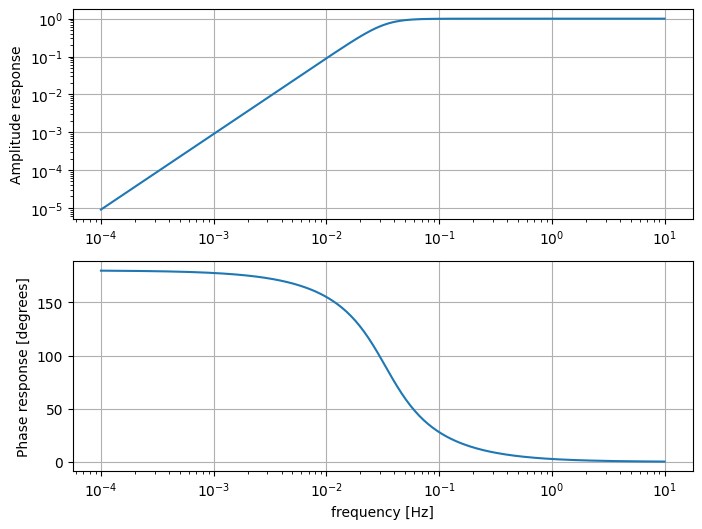

In [4]:
fig1, ax1 = plt.subplots(2,1,figsize=(8,6))

# Assume a natural frequency of 1/30 Hz (30 second natural period)
nat_freq=1/30
omega_0=2*np.pi*nat_freq

# Create a vector of frequencies over which to evaluate the instrument response. Since
# we will plot in log space, make this vector log spaced
fvec=np.logspace(-4., 1., num=int(2**8)) # frequencies in Hz from 10**-4 to 10**1
w=fvec*2*np.pi # convert from Hz to radians

wsq=w**2   # intermediate variable to simplfy writing equations

Znum=(wsq) # numerator of equation for amplitude response
Zden=np.sqrt( (wsq-omega_0**2)**2 +4*0.707**2*wsq*omega_0**2) # denominator
Zabs=Znum/Zden
ax1[0].loglog(fvec,Zabs)

ax1[0].grid(all)
ax1[0].set_ylabel('Amplitude response')


phi=np.arctan2( (2*0.707*w*omega_0),(wsq-omega_0**2))
ax1[1].semilogx(fvec,np.rad2deg(phi))
ax1[1].grid(all)
ax1[1].set_xlabel('frequency [Hz]')
ax1[1].set_ylabel('Phase response [degrees]');



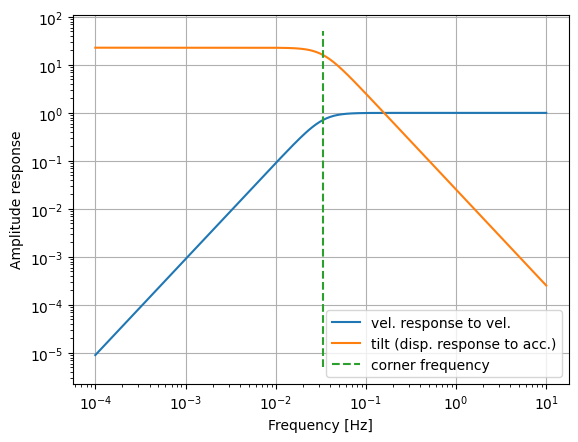

In [5]:
# plot the amplitude response again, but with the tilt response
plt.loglog(fvec,Zabs)

# divide by omega**2 to represent displacement response to acceleration
plt.loglog(fvec,Zabs/wsq) 

#plot the instrument corner frequency
plt.loglog([nat_freq, nat_freq],[5e-6, 50],'--')
plt.grid(all)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude response')

plt.legend(('vel. response to vel.', 'tilt (disp. response to acc.)', 'corner frequency'))
plt.show()



In [6]:
import matplotlib.pyplot as plt
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

irisclient = Client('IRIS')

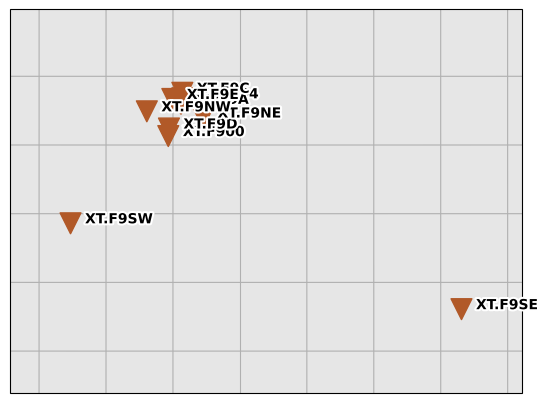

<Figure size 640x480 with 0 Axes>

In [7]:

inv = irisclient.get_stations(starttime=UTCDateTime(2009,1,12),endtime=UTCDateTime(2009,1,13),
                        network="XT",channel="HHZ")

inv.plot(projection='local');
fig=plt.gcf();


In [8]:
inv

Inventory created at 2024-02-21T20:32:17.011600Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2009-01-...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			XT
		Stations (10):
			XT.F900 (F900)
			XT.F904 (F904)
			XT.F9A (F9A)
			XT.F9C (F9C)
			XT.F9D (F9D)
			XT.F9E (F9E)
			XT.F9NE (F9NE)
			XT.F9NW (F9NW)
			XT.F9SE (F9SE)
			XT.F9SW (F9SW)
		Channels (0):


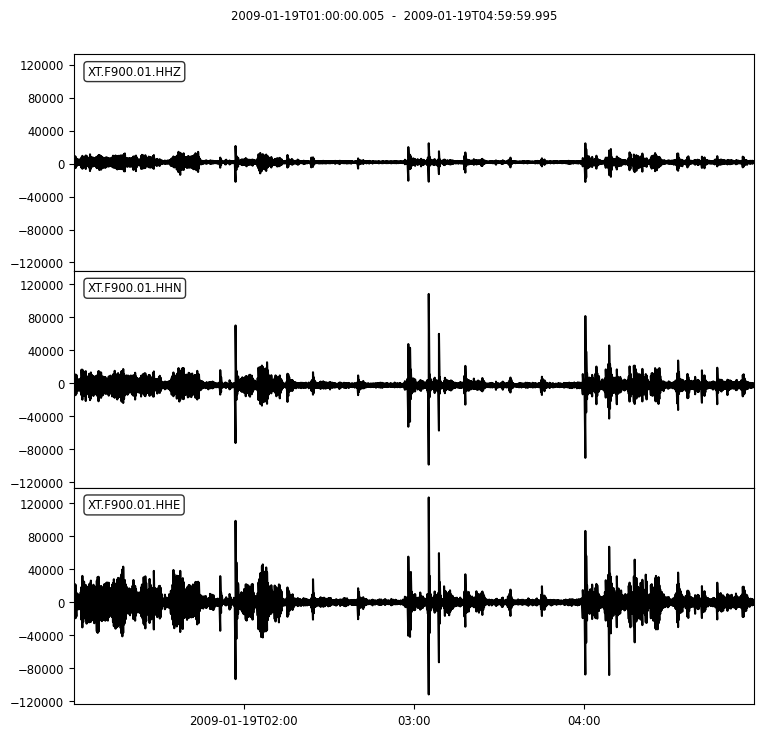

In [9]:
#continuous operation of all 10 stations was restricted to 19 January through 21 January
stime=UTCDateTime(2009,1,19,1,0,0); 

# get a few hours of data
etime=stime+60*60*4

st = irisclient.get_waveforms("XT", "F900", "01", 'HH?', stime, etime, attach_response=True)

st.plot();

In [10]:
# take a closer look at the response information
response

Channel Response
	From M/S (velocity in meters per second) to COUNTS (digital counts)
	Overall Sensitivity: 5.0925e+08 defined at 0.700 Hz
	11 stages:
		Stage 1: PolesZerosResponseStage from M/S to V, gain: 809.199
		Stage 2: ResponseStage from V to V, gain: 1
		Stage 3: CoefficientsTypeResponseStage from V to COUNTS, gain: 629330
		Stage 4: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 5: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 6: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 7: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 8: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 9: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 10: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 11: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1

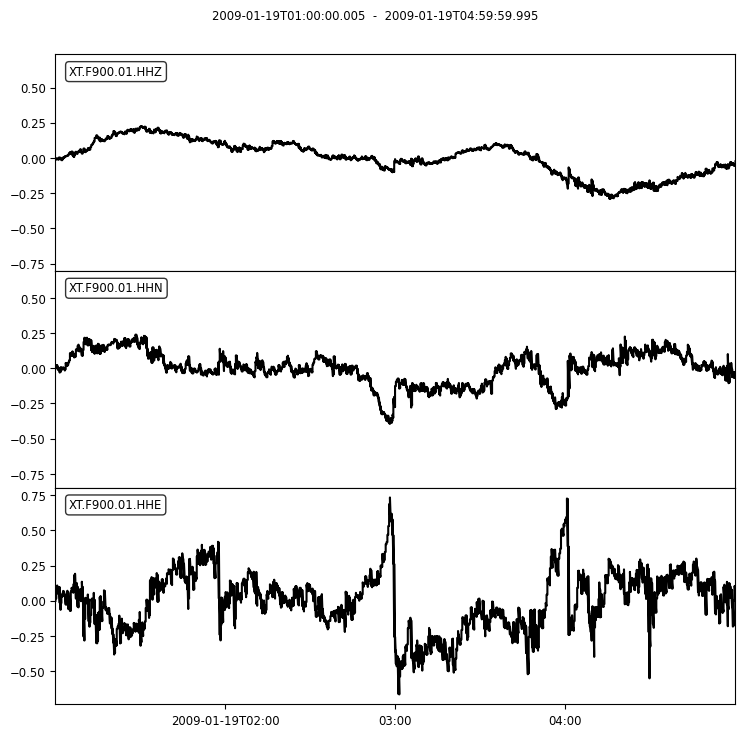

In [11]:
st.detrend('linear')

st.integrate()

nat_freq=1/30
st.filter("lowpass", freq=nat_freq)

#st.filter("highpass", freq=(1/7200))

S=1/response.instrument_sensitivity.value
scalefactor=-(S*2*np.pi*nat_freq)/9.8
for tr in st:
    tr.data=tr.data* scalefactor*1e6 # to convert to microradians
st.plot();


In [12]:
response.instrument_sensitivity.value



509250000.0

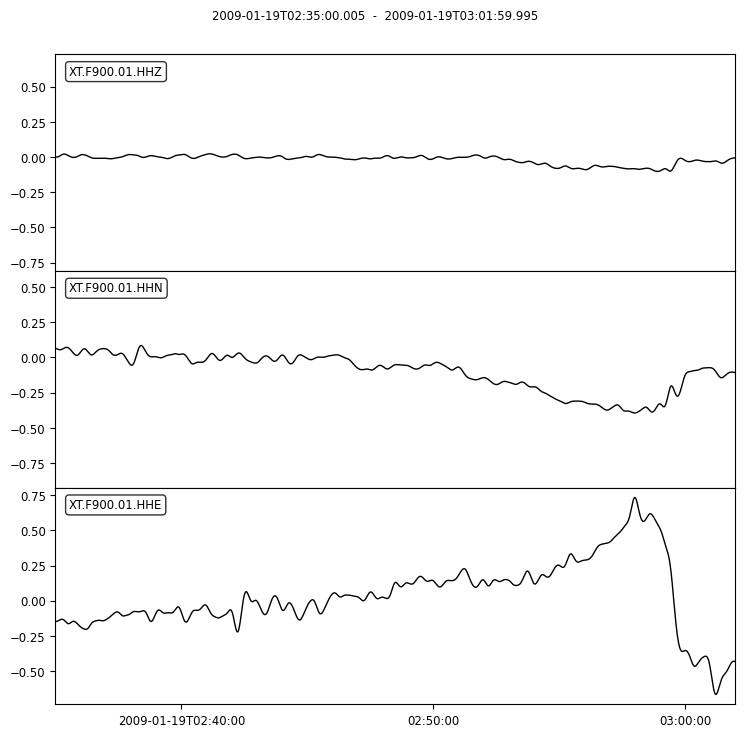

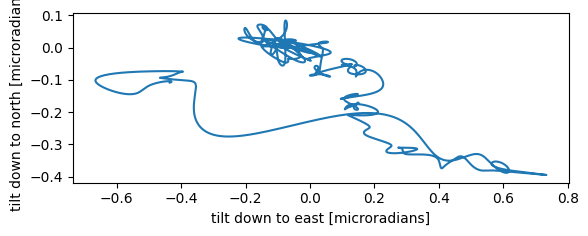

In [13]:
stcut=st.copy()
stcut.trim(UTCDateTime(2009,1,19,2,35,0),UTCDateTime(2009,1,19,3,2,0))
stcut.plot()
stn=stcut.select(component="N")
ste=stcut.select(component="E")
trn=stn[0]
tre=ste[0]
plt.plot(tre.data,trn.data)


plt.gca().set_aspect('equal', adjustable='box')

# plt.gca().set_aspect('equal')

plt.xlabel('tilt down to east [microradians]')
plt.ylabel('tilt down to north [microradians]');



Notice that the polarization angle of the <I>inflation</I> is different from the more rapid <I>deflation</I>. The data could be trimmed further before computing the inflation max direction.
--

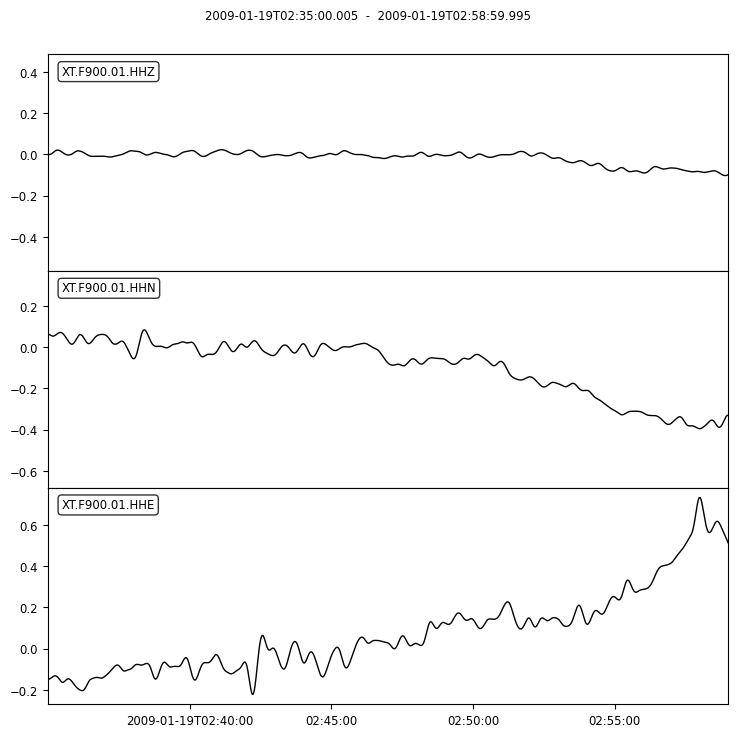

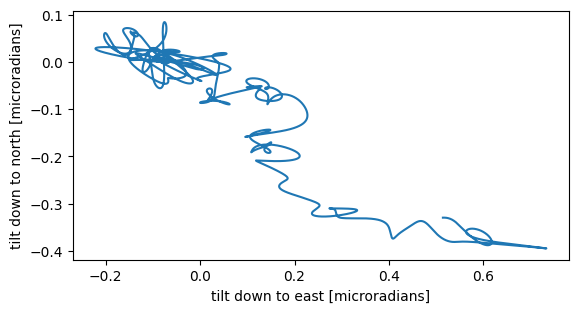

In [14]:
stcut=st.copy()
stcut.trim(UTCDateTime(2009,1,19,2,35,0),UTCDateTime(2009,1,19,2,59,0))
stcut.plot()
stn=stcut.select(component="N")
ste=stcut.select(component="E")
trn=stn[0]
tre=ste[0]
plt.plot(tre.data,trn.data)


plt.gca().set_aspect('equal', adjustable='box')

# plt.gca().set_aspect('equal')

plt.xlabel('tilt down to east [microradians]')
plt.ylabel('tilt down to north [microradians]');



In [15]:
from obspy.signal.polarization import flinn

# make sure the order is correct for the polarization analysis
# ZNE
stcut.sort(reverse=True)

azimuth, incidence, rect, plan = flinn(stcut)
print('azimuth: {}'.format(azimuth))
print('incidence: {}'.format(incidence))
print('rectilinearity: {}'.format(rect))

azimuth: 123.17026779037695
incidence: 83.3240977229536
rectilinearity: 0.8161564952770308


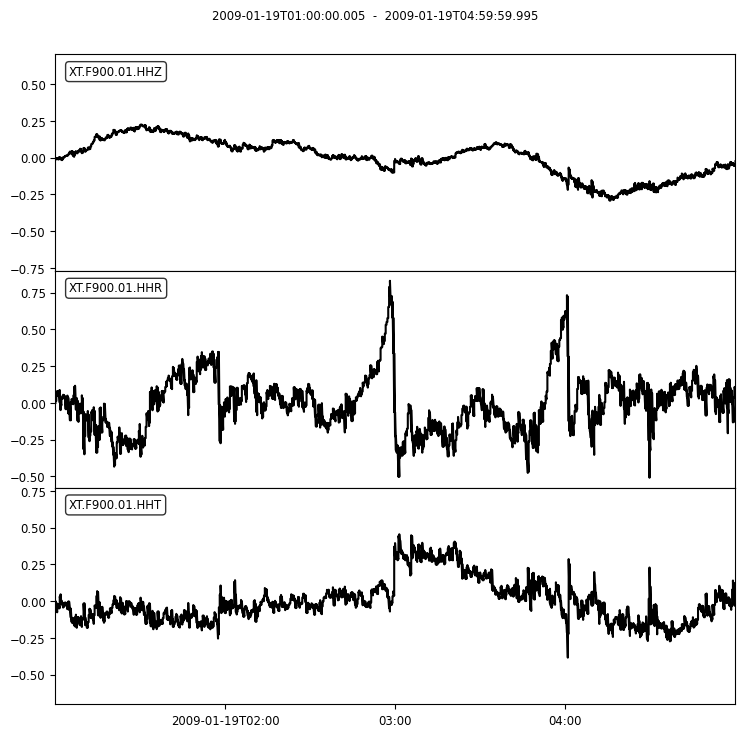

In [16]:
st.rotate('NE->RT', back_azimuth=azimuth+180)
st.plot();
# Note that 'radial' here is not radial from the vent!
# It is just used to describe the direction of max tilt

Notice that there are longer period signals visible in the data, particularly on the vertical component.

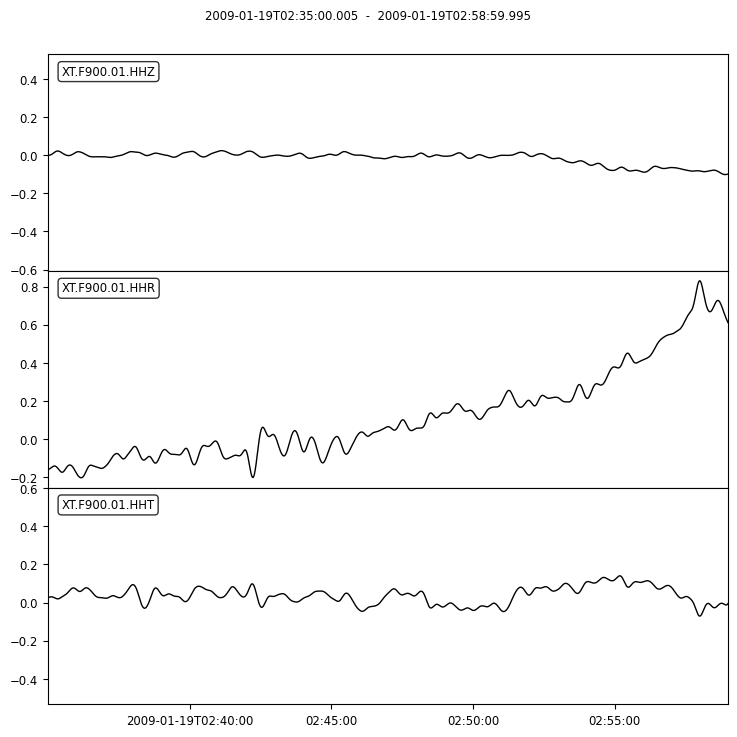

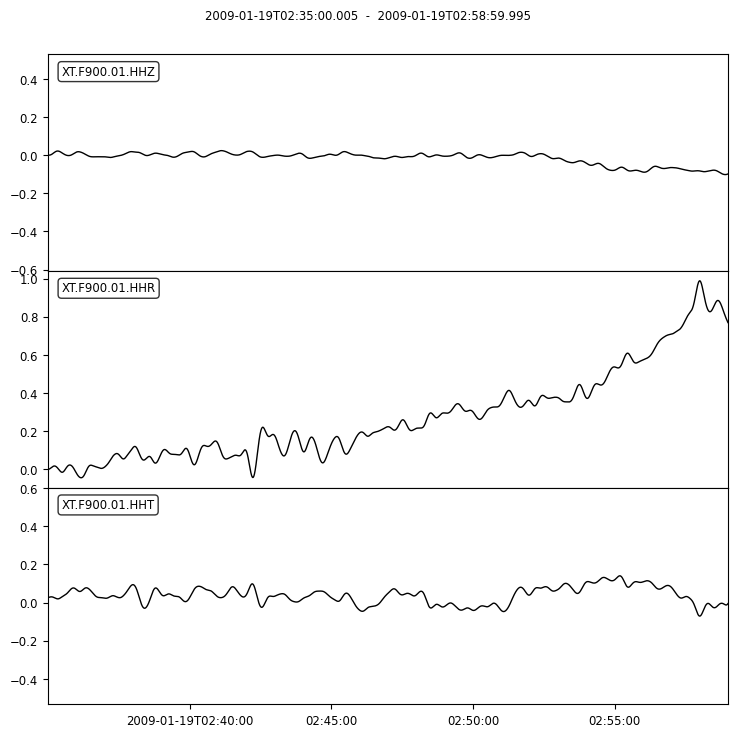

In [17]:
stcut.rotate('NE->RT', back_azimuth=azimuth+180)
stcut.plot();
stcut[1].data=stcut[1].data-stcut[1].data[0]
stcut.plot();



In [18]:
stmax=stcut.select(channel='HHR')
trmax=stmax[0]

In [19]:
print('The maximum tilt is %4.2f microradians' % max(trmax.data))
print('The tilt signal has a duration of at least 20 minutes')
print('The direction of maximum tilt is %5.2f degrees' % azimuth)

The maximum tilt is 0.99 microradians
The tilt signal has a duration of at least 20 minutes
The direction of maximum tilt is 123.17 degrees
